# ポアソン混合モデルにおける推論

## モデルの作成
データの生成モデルは
$$
p(x_n|\vec{s}_n , \vec{\lambda}) = \Pi_{k=1}^K \textbf{Poi}(x_n|\lambda_k)^{s_{nk}}
$$
パラメータの事前分布は
$$
p(\lambda_k) = \textbf{Gam}(\lambda_k|a,b)
$$
比率パラメータの事前分布は
$$
p(\vec{\pi}) = \textbf{Dir}(\vec{\pi}|\vec{\alpha})
$$
以下では，上の生成モデルからデータの生成を行えるようにします．

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, dirichlet

In [19]:
def generate_data(num_samples, num_clusters, alpha, a, b):
    # 事前分布からパラメータを生成
    
    # ディリクレ分布から混合比率をサンプリング
    pi = dirichlet.rvs(alpha, size=1)[0]

    # ガンマ分布からパラメータをサンプリング
    lambdas = []
    for k in range(num_clusters):
        lambdas.append(gamma.rvs(a[k], scale=1/b[k], size=1)[0])

    # 各データ点の所属クラスタをサンプリング
    cluster_assignments = np.random.choice(np.arange(num_clusters), size=num_samples, p=pi)

    # データ点を生成
    data = []
    for assignment in cluster_assignments :
        # 事前分布のパラメータを使ってポアソン分布からデータをサンプリング
        x = poisson.rvs(lambdas[assignment])
        data.append(x)

    return np.array(data) , lambdas, pi

In [20]:
# パラメータの設定
np.random.seed(000)
num_samples = 10000
# kurasutasuu 

num_clusters = 3
alpha = [6, 1, 7 ]
a = np.array([5, 3, 50 ])
b = np.array([1, 2, 3 ])

# データの生成
data , l ,p = generate_data(num_samples, num_clusters, alpha, a, b)

In [21]:
print("lambda: ", l)
print("pi: ", p)

lambda:  [3.0726416017808473, 2.6573076072487454, 15.395382082199617]
pi:  [0.56265459 0.04030724 0.39703816]


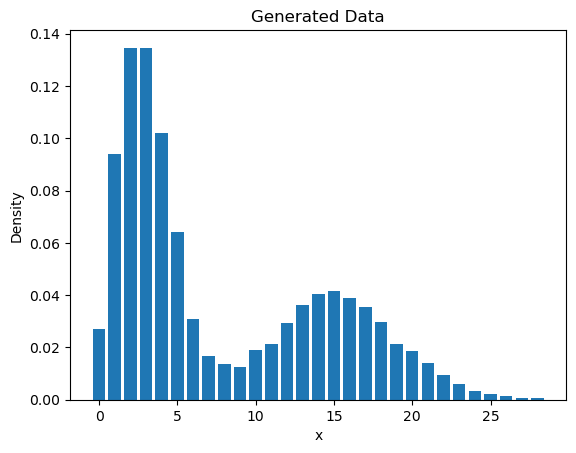

In [22]:
# データのプロット
plt.hist(data, bins=range(30), align='left', rwidth=0.8, density=True)
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Generated Data')
plt.show()

## ギブスサンプリングを用いた事後分布の推定
パラメータ$\vec{\lambda} , \vec{\pi}$と潜在変数$\vec{s_n}$の事後分布をギブスサンプリングを用いて推定します．

Re.同時分布の分解
$$
p(\vec{\Theta},\vec{\pi},\textbf{S} , \textbf{X}) = p(\textbf{X}|\vec{\Theta},\textbf{S})p(\textbf{S}|\vec{\pi})p(\vec{\Theta})p(\vec{\pi})
$$

混合分布では，潜在変数とパラメータを分けてサンプリングすると十分簡単に事後分布を推定できます．

つまり
$$
\textbf{S} \sim p(\textbf{S}|\textbf{X} ,\vec{\lambda} , \vec{\pi}) \\
\vec{\lambda} , \vec{\pi} \sim p(\vec{\lambda}, \vec{\pi}|\textbf{S} , \textbf{X}) \\
$$

更新式は以下のようになります．
$$
\vec{s_i} \sim \textbf{Cat}(\vec{s}_i|\vec{\eta_i}) \\ただし\ \eta_{ik} = \exp{\{x_i \ln{\lambda_k} - \lambda_k + \ln{\pi_k}\}}

$$
\lambda_k \sim \textbf{Gam}(\lambda_k|a + \sum_{n=1}^N s_{nk} x_n , b + \sum_{n=1}^N s_{nk}) \\

$$
\vec{\pi} \sim \textbf{Dir}(\vec{\pi}|\vec{\alpha} + \sum_{n=1}^N \vec{s}_n)
$$

In [23]:
# 本来クラスタ数は未知
num_clusters = 3
# 非情報的な事前分布のパラメータ
prior_alpha = np.array([1, 1, 1])
prior_a = np.array([1, 1, 1])
prior_b = np.array([1, 1, 1])

/tmp/ipykernel_3925019/422904283.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lambdas, pi]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 208 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/tmp/ipykernel_3925019/422904283.py:20: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, var_names=['pi', 'lambdas'])
/home/mori/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mori/anaconda3/lib/python3.10/site-packages/

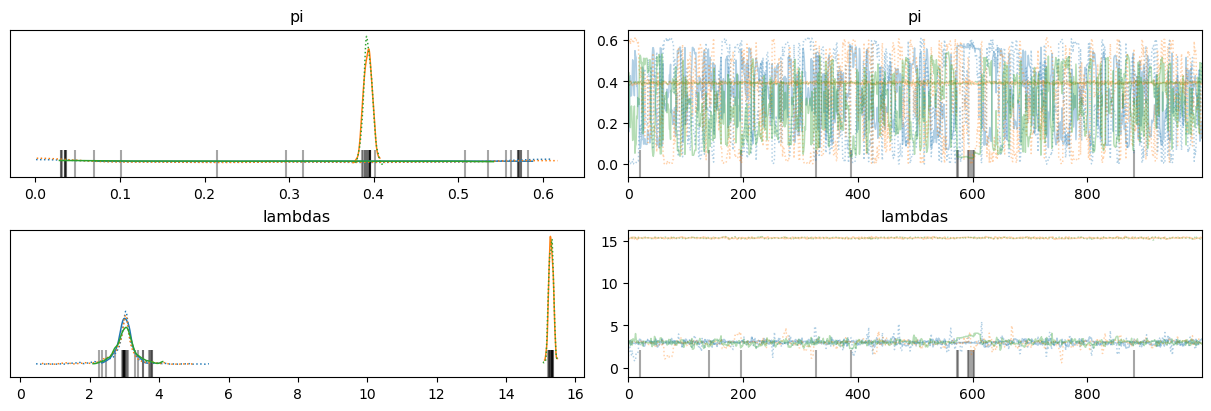

In [24]:
# 混合ポアソンモデルの定義
with pm.Model() as model:
    # ディリクレ分布から混合比率をサンプリング
    pi = pm.Dirichlet("pi", a=prior_alpha, shape=num_clusters)
    
    # ガンマ分布からポアソン分布のパラメータ lambda をサンプリング
    lambdas = pm.Gamma("lambdas", alpha=prior_a, beta=prior_b, shape=num_clusters)
    
    # 混合ポアソン分布の各成分を定義
    poissons = [pm.Poisson.dist(mu=lambdas[k]) for k in range(num_clusters)]
    
    # 混合ポアソン分布の尤度
    obs = pm.Mixture("obs", w=pi, comp_dists=poissons, observed=data)

# サンプリングの実行
with model:
    trace = pm.sample(1000, chains=2)

# 結果の表示
pm.traceplot(trace, var_names=['pi', 'lambdas'])
pm.summary(trace, var_names=['pi', 'lambdas'])
plt.show()

In [25]:
# 真のパラメータと推定値の比較
print("True lambdas: ", l)
print("True pi: ", p)

True lambdas:  [3.0726416017808473, 2.6573076072487454, 15.395382082199617]
True pi:  [0.56265459 0.04030724 0.39703816]
